In [18]:
# Imports --- All of this may not be vital


import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss, f1_score, fbeta_score, recall_score, precision_score, confusion_matrix



from pprint import pprint
from sklearn.preprocessing import MinMaxScaler


from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import *

In [19]:
# Import data
import pickle
with open("ESM_train_features_final_original.pkl","rb") as f:
    corona_final = pickle.load(f)
with open("ESM_test_features_final.pkl","rb") as f:
    test = pickle.load(f)
corona_final

,Corona,Protein names,Short names,ESM features
0,0,Serum albumin,Albumin,"[-0.050140176, -0.052733008, -0.078817025, 0.0..."
1,1,Haptoglobin (Zonulin) [Cleaved into: Haptoglob...,Haptoglobin,"[0.0064989347, -0.020802459, 0.012509024, 0.00..."
2,1,Immunoglobulin kappa constant (Ig kappa chain ...,Immunoglobulin kappa constant,"[0.057951685, -0.10169613, -0.048828438, 0.163..."
3,1,Immunoglobulin heavy constant gamma 1 (Ig gamm...,Immunoglobulin heavy constant gamma 1,"[0.0092305485, -0.14546646, -0.07357601, 0.218..."
4,0,Serotransferrin (Transferrin) (Beta-1 metal-bi...,Serotransferrin,"[-0.05455521, -0.052603737, -0.06821843, 0.130..."
...,...,...,...,...
169,0,Hemoglobin subunit beta (Beta-globin) (Hemoglo...,Hemoglobin subunit beta,"[-0.012229192, -0.07183029, -0.122249745, 0.03..."
170,0,Haptoglobin (Zonulin) [Cleaved into: Haptoglob...,Haptoglobin,"[0.0064989347, -0.020802459, 0.012509024, 0.00..."
171,0,Immunoglobulin heavy constant alpha 1 (Ig alph...,Immunoglobulin heavy constant alpha 1,"[0.04001641, -0.077039436, -0.009125997, 0.053..."
172,0,Immunoglobulin lambda constant 7 (Ig lambda-7 ...,Immunoglobulin lambda constant 7,"[0.018185293, -0.07679449, -0.02555966, 0.0750..."


In [20]:
#This is the label, whether protein is in/out of corona
names_merged = corona_final["Corona"].copy()
names_merged

0      0
1      1
2      1
3      1
4      0
      ..
169    0
170    0
171    0
172    0
173    1
Name: Corona, Length: 173, dtype: int64

In [21]:
nfeatures = len(corona_final.iloc[0]["ESM features"])

In [51]:
features = corona_final.copy()
features_df = features["ESM features"].apply(pd.Series)
features_df.columns = np.arange(nfeatures)
features = pd.concat([features.drop("ESM features",axis=1), features_df], axis=1)
features_merged = features.copy()

In [52]:
test_set = test.copy()
test_set_df = test_set["ESM features"].apply(pd.Series)
test_set_df.columns = np.arange(nfeatures)
test_set = pd.concat([test_set.drop("ESM features",axis=1), test_set_df], axis=1)

In [53]:
df_local_features_train = features_merged.drop(columns=["Corona","Protein names","Short names"])
df_local_features_classify = test_set.drop(columns=["Protein names"])

In [54]:
df_local_names = names_merged.copy()
df_local_protein_names_classify = test_set["Protein names"]

In [55]:
df_local_features_train_copy = df_local_features_train.copy()
df_local_names_copy = names_merged.copy()
df_local_features_classify_copy = df_local_features_classify.copy()
df_local_protein_names_classify_copy = df_local_protein_names_classify.copy()

# Classifier

In [56]:
k_fold_splits = 100
predictions = pd.DataFrame()

X_new = SelectKBest(f_classif, k=120).fit_transform(df_local_features_train.copy(), df_local_names.copy()) #X_train_set.values #
selector = SelectKBest(f_classif, k=120).fit(df_local_features_train.copy(), df_local_names.copy()) 
df_local_features_train = pd.DataFrame(X_new.copy())#df_local_features_train.copy() #pd.DataFrame(X_new.copy()) #scaled_df.copy()

#reduce features
k_selected_features = selector.get_support()
k_selected_df_local_features_classify = df_local_features_classify[df_local_features_classify.columns[k_selected_features]]

rndm_ste=2016
feature_imp = pd.DataFrame(columns=list(df_local_features_train.columns))
first_frame = True
correctness_frame = pd.DataFrame()
metrics_frame = pd.DataFrame()

#set_size_adjust = (scaled_df.shape[0]/scaled_df_plasma.shape[0]) *.1 # used to retain the same number of samples in the test set, replace test_size with it if using
# #split up our data
i = 0

sss = StratifiedShuffleSplit(n_splits=k_fold_splits, test_size=0.1, random_state=rndm_ste)

for train_index, test_index in sss.split(df_local_features_train, df_local_names): # comment our if doing cross fluid
# for train_index, test_index in sss.split(scaled_df_plasma, names_plasma): # use for cross fluid tests, verify correct dataset placed here
    X_train = df_local_features_train.iloc[train_index] # remove subsetting for cross fluid tests
    X_test = df_local_features_train.iloc[test_index] # change dataframe for cross fluid tests
    y_train = df_local_names.iloc[train_index] # remove subsetting for cross fluid tests
    y_test = df_local_names.iloc[test_index] # change dataframe for cross fluid tests


     
    # Create and Train
    rfc=RandomForestClassifier(criterion='entropy', min_impurity_decrease = 0.02,  min_samples_split=2, max_depth = 10, max_features = 'sqrt',
     n_jobs=-1, ccp_alpha=0.01, random_state=rndm_ste, n_estimators=700) 
 
    
    sme = SMOTE(random_state=rndm_ste, sampling_strategy=0.7, n_jobs=-1, k_neighbors=12)
    X_train_oversampled, y_train_oversampled = sme.fit_resample(X_train, y_train)
    #X_train_oversampled, y_train_oversampled = X_train, y_train # can be used to pass smote if needed for an experiment
    rfc.fit(X_train_oversampled,y_train_oversampled)


    

    if first_frame:  # Initialize 
        first_frame = False  # Don't Come back Here
        
        datadict = {'true':y_test.to_numpy(), 'estimate':rfc.predict(X_test), 'probability':rfc.predict_proba(X_test)[:, 1]}
        
        correctness_frame = pd.DataFrame(data=datadict)
        correctness_frame['round'] = i

        metrics_dict = {'AUC':metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]),
        'Accuracy':rfc.score(X_test, y_test), 'Recall':recall_score(y_test, rfc.predict(X_test)), 
        'Precision':precision_score(y_test, rfc.predict(X_test)), 'F1':f1_score(y_test, rfc.predict(X_test))}
        
        metrics_frame = pd.DataFrame.from_dict(data=metrics_dict,orient='index').transpose()
        metrics_frame['Round'] = i

        # can be used if you want to track prediction during shuffle split - saves in another cell
        predictions = pd.DataFrame()
        predictions['Protein Name'] = df_local_protein_names_classify
        predictions['In Corona Probability'] = rfc.predict_proba(k_selected_df_local_features_classify)[:, 1]
        predictions['Round'] = i
        predictions['Test Accuracy'] = metrics_dict['Accuracy']
        predictions['Test Recall'] = metrics_dict['Recall']
        predictions['Test Precision'] = metrics_dict['Precision']
        predictions['Test AUC'] = metrics_dict['AUC']

        
    else:
        datadict = {'true':y_test.to_numpy(), 'estimate':rfc.predict(X_test), 'probability':rfc.predict_proba(X_test)[:, 1]}
        revolve_frame = pd.DataFrame(data=datadict)
        revolve_frame['round'] = i
        #correctness_frame = correctness_frame.append(revolve_frame, ignore_index=True)
        correctness_frame = pd.concat([correctness_frame, revolve_frame], ignore_index=True)
        metrics_dict = {'AUC':metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]),
        'Accuracy':rfc.score(X_test, y_test), 'Recall':recall_score(y_test, rfc.predict(X_test)), 
        'Precision':precision_score(y_test, rfc.predict(X_test)), 'F1':f1_score(y_test, rfc.predict(X_test))}
        metrics_revolve_frame = pd.DataFrame.from_dict(data=metrics_dict, orient='index').transpose()
        metrics_revolve_frame['Round'] = i
        #metrics_frame = metrics_frame.append(metrics_revolve_frame, ignore_index=True)
        metrics_frame = pd.concat([metrics_frame,metrics_revolve_frame],ignore_index=True)
        # can be used if you want to track prediction during shuffle split - saves in another cell
        pred_rev = pd.DataFrame()
        pred_rev['Protein Name'] = df_local_protein_names_classify
        pred_rev['In Corona Probability'] = rfc.predict_proba(k_selected_df_local_features_classify)[:, 1]
        pred_rev['Round'] = i
        pred_rev['Test Accuracy'] = metrics_dict['Accuracy']
        pred_rev['Test Recall'] = metrics_dict['Recall']
        pred_rev['Test Precision'] = metrics_dict['Precision']
        pred_rev['Test AUC'] = metrics_dict['AUC']

        #predictions = predictions.append(pred_rev, ignore_index=True)
        predictions = pd.concat([predictions,pred_rev],ignore_index=True)


    
    feature_imp.loc[i] = pd.Series(rfc.feature_importances_,index=list(df_local_features_train.columns))
    
    i += 1

/home/anhtn/miniconda3/envs/nanobio/lib/python3.12/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/home/anhtn/miniconda3/envs/nanobio/lib/python3.12/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/home/anhtn/miniconda3/envs/nanobio/lib/python3.12/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/home/anhtn/miniconda3/envs/nanobio/lib/python3.12/site-packages/imblearn/over_sampling/_sm

In [65]:
metrics_frame.mean()

AUC           0.755625
Accuracy      0.773333
Recall        0.595000
Precision     0.708032
F1            0.627313
Round        49.500000
dtype: float64

In [58]:
esm_metrics = metrics_frame.mean()
esm_metrics.to_pickle("esm_metrics.pkl")

In [61]:
metrics_std = metrics_frame.std()
metrics_std.to_pickle("esm_metrics_std.pkl")

In [40]:
#150 features
metrics_frame.mean()

AUC           0.755625
Accuracy      0.773333
Recall        0.595000
Precision     0.708032
F1            0.627313
Round        49.500000
dtype: float64

In [34]:
#38 features
metrics_frame.mean()

AUC           0.584583
Accuracy      0.620000
Recall        0.362500
Precision     0.387310
F1            0.349082
Round        49.500000
dtype: float64

In [66]:
X_train_total = df_local_features_train_copy.copy() #df_local_features_train #df_local_features_train_copy
y_train_total = df_local_names #df_local_names#df_local_names_copy
rndm_ste = 2016
k_best = SelectKBest(f_classif, k=120)
fit = k_best.fit(X_train_total, y_train_total)
X_new = fit.transform(X_train_total)
 #X_train_set.values #
X_train_total = pd.DataFrame(X_new.copy())

rfc=RandomForestClassifier(criterion='entropy', min_impurity_decrease = 0.02,  min_samples_split=2, max_depth = 10, max_features = 'sqrt',
     n_jobs=-1, ccp_alpha=0.01, random_state=rndm_ste, n_estimators=700)   
sme = SMOTE(random_state=2016, sampling_strategy=0.7, n_jobs=-1, k_neighbors=12)
X_train_oversampled, y_train_oversampled = sme.fit_resample(X_train_total, y_train_total)
rfc.fit(X_train_oversampled,y_train_oversampled)


total_train_test = pd.DataFrame()
total_train_test['Protein Name'] = df_local_protein_names_classify_copy
# pd.DataFrame(fit.transform(df_local_features_classify_copy))
# total_train_test['In Corona Probability'] = rfc.predict_proba(df_local_features_classify_copy)[:, 1]

print(len(k_best.get_support()), df_local_features_train_copy.shape)
total_train_test['In Corona Probability'] = rfc.predict_proba(pd.DataFrame(df_local_features_classify_copy.loc[:,k_best.get_support()]))[:, 1]

/home/anhtn/miniconda3/envs/nanobio/lib/python3.12/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


1280 (173, 1280)


In [67]:
total_train_test

,Protein Name,In Corona Probability
0,Transgelin,0.381995
1,TAR DNA-binding protein 43,0.384908
2,CD44 antigen,0.502649
3,Lysozyme C,0.580379
4,L-lactate dehydrogenase A chain,0.242026
5,Ribonuclease pancreatic,0.410356
6,Glutathione S-transferase,0.218583
7,Syntenin-1,0.232698


In [74]:

from matplotlib import font_manager
import matplotlib.ticker as ticker

#set up font importing
font_path = '/home/anhtn/fonts/Helvetica'
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

def figure_formatting(): # make the plot look xmgrace-esque
    font = {'size': 16,'family': 'sans-serif'} #
    plt.rcParams['font.sans-serif'] = ['Helvetica']
    plt.rc('font', **font)
    plt.rcParams['axes.linewidth'] = 2.0
    plt.rcParams['xtick.major.size'] = 10
    plt.rcParams['xtick.minor.size'] = 5
    plt.rcParams['xtick.major.width'] = 2.0
    plt.rcParams['xtick.minor.width'] = 2.0
    plt.rcParams['ytick.major.size'] = 10
    plt.rcParams['ytick.minor.size'] = 5
    plt.rcParams['ytick.major.width'] = 2.0
    plt.rcParams['ytick.minor.width'] = 2.0
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['mathtext.default'] = 'regular'
    plt.rcParams['legend.fancybox'] = False # no rounded legend box
import datetime

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_87524/1767797413.py:13: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("Final Cy5-(GT)$_{15}$ ($\mu$M)")


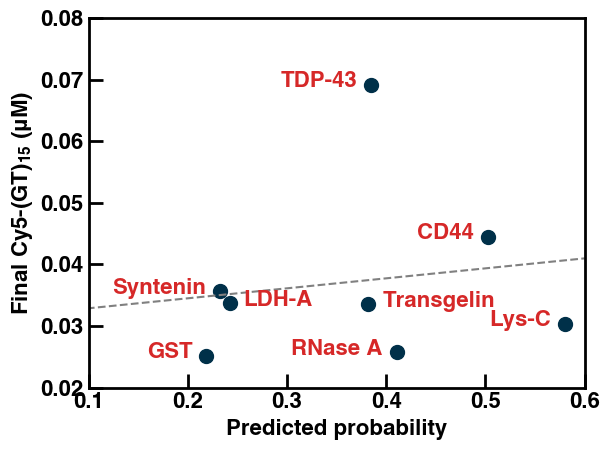

In [108]:
total_train_test["Experimental"] = [3.35E-2,6.92E-2,4.45E-2,3.04E-2,3.37E-2,2.57E-2,2.52E-2,3.57E-2]
name = ["Transgelin","TDP-43","CD44","Lys-C","LDH-A","RNase A","GST","Syntenin"]
xarr=total_train_test["In Corona Probability"]
yarr=total_train_test["Experimental"] 
plt.scatter(total_train_test["In Corona Probability"],total_train_test["Experimental"],s=100, color = "#003049")
slope, intercept = np.polyfit(total_train_test["In Corona Probability"], total_train_test["Experimental"], 1)
x = np.linspace(0,0.6,100)
y_fit = slope * x + intercept
plt.plot(x,y_fit,"--",color="grey")
plt.xlim([0.1,0.6])
plt.ylim([0.02,0.08])
plt.xlabel("Predicted probability")
plt.ylabel("Final Cy5-(GT)$_{15}$ ($\mu$M)")
figure_formatting()
for i in range(len(xarr)):
    if i == 0 or i == 4:
        plt.annotate(name[i],  # Text: displaying the (x, y) value
                (xarr[i], yarr[i]),             # Position: coordinates of the point
                textcoords="offset points",  # Use offset positioning
                xytext=(10, -2),             # Offset text by (x, y)
                ha='left',               # Horizontal alignment (centered)
                fontsize=16,                # Font size
                color='#d62828')               # Text color 
    else:
        plt.annotate(name[i],  # Text: displaying the (x, y) value
                (xarr[i], yarr[i]),             # Position: coordinates of the point
                textcoords="offset points",  # Use offset positioning
                xytext=(-10, -2),             # Offset text by (x, y)
                ha='right',               # Horizontal alignment (centered)
                fontsize=16,                # Font size
                color='#d62828')               # Text color


# Grid search

In [27]:
all_metrics = []
num_feature_list = [40,50,70,80,90,100,120,150,200,250,300]

In [28]:
for num_feature in num_feature_list:
    
    df_local_features_train = features_merged.drop(columns=["Corona","Protein names","Short names"])
    df_local_features_classify = test_set.drop(columns=["Protein names"])
    
    k_fold_splits = 50
    predictions = pd.DataFrame()

    X_new = SelectKBest(f_classif, k=num_feature).fit_transform(df_local_features_train.copy(), df_local_names.copy()) #X_train_set.values #
    selector = SelectKBest(f_classif, k=num_feature).fit(df_local_features_train.copy(), df_local_names.copy()) 
    df_local_features_train = pd.DataFrame(X_new.copy())#df_local_features_train.copy() #pd.DataFrame(X_new.copy()) #scaled_df.copy()

    #reduce features
    k_selected_features = selector.get_support()
    k_selected_df_local_features_classify = df_local_features_classify[df_local_features_classify.columns[k_selected_features]]

    rndm_ste=2016
    feature_imp = pd.DataFrame(columns=list(df_local_features_train.columns))
    first_frame = True
    correctness_frame = pd.DataFrame()
    metrics_frame = pd.DataFrame()

    #set_size_adjust = (scaled_df.shape[0]/scaled_df_plasma.shape[0]) *.1 # used to retain the same number of samples in the test set, replace test_size with it if using
    # #split up our data
    i = 0

    sss = StratifiedShuffleSplit(n_splits=k_fold_splits, test_size=0.1, random_state=rndm_ste)

    for train_index, test_index in sss.split(df_local_features_train, df_local_names): # comment our if doing cross fluid
    # for train_index, test_index in sss.split(scaled_df_plasma, names_plasma): # use for cross fluid tests, verify correct dataset placed here
        X_train = df_local_features_train.iloc[train_index] # remove subsetting for cross fluid tests
        X_test = df_local_features_train.iloc[test_index] # change dataframe for cross fluid tests
        y_train = df_local_names.iloc[train_index] # remove subsetting for cross fluid tests
        y_test = df_local_names.iloc[test_index] # change dataframe for cross fluid tests


        
        # Create and Train
        rfc=RandomForestClassifier(criterion='entropy', min_impurity_decrease = 0.02,  min_samples_split=2, max_depth = 10, max_features = 'sqrt',
        n_jobs=-1, ccp_alpha=0.01, random_state=rndm_ste, n_estimators=700) 
    
        
        sme = SMOTE(random_state=rndm_ste, sampling_strategy=0.7, n_jobs=-1, k_neighbors=12)
        X_train_oversampled, y_train_oversampled = sme.fit_resample(X_train, y_train)
        # X_train_oversampled, y_train_oversampled = X_train, y_train # can be used to pass smote if needed for an experiment
        rfc.fit(X_train_oversampled,y_train_oversampled)


        

        if first_frame:  # Initialize 
            first_frame = False  # Don't Come back Here
            
            datadict = {'true':y_test.to_numpy(), 'estimate':rfc.predict(X_test), 'probability':rfc.predict_proba(X_test)[:, 1]}
            
            correctness_frame = pd.DataFrame(data=datadict)
            correctness_frame['round'] = i

            metrics_dict = {'AUC':metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]),
            'Accuracy':rfc.score(X_test, y_test), 'Recall':recall_score(y_test, rfc.predict(X_test)), 
            'Precision':precision_score(y_test, rfc.predict(X_test)), 'F1':f1_score(y_test, rfc.predict(X_test))}
            
            metrics_frame = pd.DataFrame.from_dict(data=metrics_dict,orient='index').transpose()
            metrics_frame['Round'] = i

            # can be used if you want to track prediction during shuffle split - saves in another cell
            predictions = pd.DataFrame()
            predictions['Protein Name'] = df_local_protein_names_classify
            predictions['In Corona Probability'] = rfc.predict_proba(k_selected_df_local_features_classify)[:, 1]
            predictions['Round'] = i
            predictions['Test Accuracy'] = metrics_dict['Accuracy']
            predictions['Test Recall'] = metrics_dict['Recall']
            predictions['Test Precision'] = metrics_dict['Precision']
            predictions['Test AUC'] = metrics_dict['AUC']

            
        else:
            datadict = {'true':y_test.to_numpy(), 'estimate':rfc.predict(X_test), 'probability':rfc.predict_proba(X_test)[:, 1]}
            revolve_frame = pd.DataFrame(data=datadict)
            revolve_frame['round'] = i
            #correctness_frame = correctness_frame.append(revolve_frame, ignore_index=True)
            correctness_frame = pd.concat([correctness_frame, revolve_frame], ignore_index=True)
            metrics_dict = {'AUC':metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]),
            'Accuracy':rfc.score(X_test, y_test), 'Recall':recall_score(y_test, rfc.predict(X_test)), 
            'Precision':precision_score(y_test, rfc.predict(X_test)), 'F1':f1_score(y_test, rfc.predict(X_test))}
            metrics_revolve_frame = pd.DataFrame.from_dict(data=metrics_dict, orient='index').transpose()
            metrics_revolve_frame['Round'] = i
            #metrics_frame = metrics_frame.append(metrics_revolve_frame, ignore_index=True)
            metrics_frame = pd.concat([metrics_frame,metrics_revolve_frame],ignore_index=True)
            # can be used if you want to track prediction during shuffle split - saves in another cell
            pred_rev = pd.DataFrame()
            pred_rev['Protein Name'] = df_local_protein_names_classify
            pred_rev['In Corona Probability'] = rfc.predict_proba(k_selected_df_local_features_classify)[:, 1]
            pred_rev['Round'] = i
            pred_rev['Test Accuracy'] = metrics_dict['Accuracy']
            pred_rev['Test Recall'] = metrics_dict['Recall']
            pred_rev['Test Precision'] = metrics_dict['Precision']
            pred_rev['Test AUC'] = metrics_dict['AUC']

            #predictions = predictions.append(pred_rev, ignore_index=True)
            predictions = pd.concat([predictions,pred_rev],ignore_index=True)


        
        feature_imp.loc[i] = pd.Series(rfc.feature_importances_,index=list(df_local_features_train.columns))
        
        i += 1
    metrics_current = list(metrics_frame.mean())
    all_metrics.append(metrics_current)

/home/anhtn/miniconda3/envs/nanobio/lib/python3.12/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/home/anhtn/miniconda3/envs/nanobio/lib/python3.12/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/home/anhtn/miniconda3/envs/nanobio/lib/python3.12/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/home/anhtn/miniconda3/envs/nanobio/lib/python3.12/site-packages/imblearn/over_sampling/_sm

In [29]:
[i[1] for i in all_metrics]

[0.7733333333333334,
 0.7633333333333333,
 0.771111111111111,
 0.7744444444444444,
 0.7733333333333333,
 0.7688888888888888,
 0.7788888888888889,
 0.7755555555555554,
 0.7677777777777777,
 0.7666666666666666,
 0.7666666666666666]

In [47]:
all_metrics_new = []
num_feature_list = [149,150,151,152,153,155]
for num_feature in num_feature_list:
    
    df_local_features_train = features_merged.drop(columns=["Corona","Protein names","Short names"])
    df_local_features_classify = test_set.drop(columns=["Protein names"])
    
    k_fold_splits = 100
    predictions = pd.DataFrame()

    X_new = SelectKBest(f_classif, k=num_feature).fit_transform(df_local_features_train.copy(), df_local_names.copy()) #X_train_set.values #
    selector = SelectKBest(f_classif, k=num_feature).fit(df_local_features_train.copy(), df_local_names.copy()) 
    df_local_features_train = pd.DataFrame(X_new.copy())#df_local_features_train.copy() #pd.DataFrame(X_new.copy()) #scaled_df.copy()

    #reduce features
    k_selected_features = selector.get_support()
    k_selected_df_local_features_classify = df_local_features_classify[df_local_features_classify.columns[k_selected_features]]

    rndm_ste=2016
    feature_imp = pd.DataFrame(columns=list(df_local_features_train.columns))
    first_frame = True
    correctness_frame = pd.DataFrame()
    metrics_frame = pd.DataFrame()

    #set_size_adjust = (scaled_df.shape[0]/scaled_df_plasma.shape[0]) *.1 # used to retain the same number of samples in the test set, replace test_size with it if using
    # #split up our data
    i = 0

    sss = StratifiedShuffleSplit(n_splits=k_fold_splits, test_size=0.1, random_state=rndm_ste)

    for train_index, test_index in sss.split(df_local_features_train, df_local_names): # comment our if doing cross fluid
    # for train_index, test_index in sss.split(scaled_df_plasma, names_plasma): # use for cross fluid tests, verify correct dataset placed here
        X_train = df_local_features_train.iloc[train_index] # remove subsetting for cross fluid tests
        X_test = df_local_features_train.iloc[test_index] # change dataframe for cross fluid tests
        y_train = df_local_names.iloc[train_index] # remove subsetting for cross fluid tests
        y_test = df_local_names.iloc[test_index] # change dataframe for cross fluid tests


        
        # Create and Train
        rfc=RandomForestClassifier(criterion='entropy', min_impurity_decrease = 0.02,  min_samples_split=2, max_depth = 10, max_features = 'sqrt',
        n_jobs=-1, ccp_alpha=0.01, random_state=rndm_ste, n_estimators=700) 
    
        
        sme = SMOTE(random_state=rndm_ste, sampling_strategy=0.7, n_jobs=-1, k_neighbors=12)
        X_train_oversampled, y_train_oversampled = sme.fit_resample(X_train, y_train)
        # X_train_oversampled, y_train_oversampled = X_train, y_train # can be used to pass smote if needed for an experiment
        rfc.fit(X_train_oversampled,y_train_oversampled)


        

        if first_frame:  # Initialize 
            first_frame = False  # Don't Come back Here
            
            datadict = {'true':y_test.to_numpy(), 'estimate':rfc.predict(X_test), 'probability':rfc.predict_proba(X_test)[:, 1]}
            
            correctness_frame = pd.DataFrame(data=datadict)
            correctness_frame['round'] = i

            metrics_dict = {'AUC':metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]),
            'Accuracy':rfc.score(X_test, y_test), 'Recall':recall_score(y_test, rfc.predict(X_test)), 
            'Precision':precision_score(y_test, rfc.predict(X_test)), 'F1':f1_score(y_test, rfc.predict(X_test))}
            
            metrics_frame = pd.DataFrame.from_dict(data=metrics_dict,orient='index').transpose()
            metrics_frame['Round'] = i

            # can be used if you want to track prediction during shuffle split - saves in another cell
            predictions = pd.DataFrame()
            predictions['Protein Name'] = df_local_protein_names_classify
            predictions['In Corona Probability'] = rfc.predict_proba(k_selected_df_local_features_classify)[:, 1]
            predictions['Round'] = i
            predictions['Test Accuracy'] = metrics_dict['Accuracy']
            predictions['Test Recall'] = metrics_dict['Recall']
            predictions['Test Precision'] = metrics_dict['Precision']
            predictions['Test AUC'] = metrics_dict['AUC']

            
        else:
            datadict = {'true':y_test.to_numpy(), 'estimate':rfc.predict(X_test), 'probability':rfc.predict_proba(X_test)[:, 1]}
            revolve_frame = pd.DataFrame(data=datadict)
            revolve_frame['round'] = i
            #correctness_frame = correctness_frame.append(revolve_frame, ignore_index=True)
            correctness_frame = pd.concat([correctness_frame, revolve_frame], ignore_index=True)
            metrics_dict = {'AUC':metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]),
            'Accuracy':rfc.score(X_test, y_test), 'Recall':recall_score(y_test, rfc.predict(X_test)), 
            'Precision':precision_score(y_test, rfc.predict(X_test)), 'F1':f1_score(y_test, rfc.predict(X_test))}
            metrics_revolve_frame = pd.DataFrame.from_dict(data=metrics_dict, orient='index').transpose()
            metrics_revolve_frame['Round'] = i
            #metrics_frame = metrics_frame.append(metrics_revolve_frame, ignore_index=True)
            metrics_frame = pd.concat([metrics_frame,metrics_revolve_frame],ignore_index=True)
            # can be used if you want to track prediction during shuffle split - saves in another cell
            pred_rev = pd.DataFrame()
            pred_rev['Protein Name'] = df_local_protein_names_classify
            pred_rev['In Corona Probability'] = rfc.predict_proba(k_selected_df_local_features_classify)[:, 1]
            pred_rev['Round'] = i
            pred_rev['Test Accuracy'] = metrics_dict['Accuracy']
            pred_rev['Test Recall'] = metrics_dict['Recall']
            pred_rev['Test Precision'] = metrics_dict['Precision']
            pred_rev['Test AUC'] = metrics_dict['AUC']

            #predictions = predictions.append(pred_rev, ignore_index=True)
            predictions = pd.concat([predictions,pred_rev],ignore_index=True)


        
        feature_imp.loc[i] = pd.Series(rfc.feature_importances_,index=list(df_local_features_train.columns))
        
        i += 1
    metrics_current = list(metrics_frame.mean())
    all_metrics_new.append(metrics_current)

/home/anhtn/miniconda3/envs/nanobio/lib/python3.12/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/home/anhtn/miniconda3/envs/nanobio/lib/python3.12/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/home/anhtn/miniconda3/envs/nanobio/lib/python3.12/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/home/anhtn/miniconda3/envs/nanobio/lib/python3.12/site-packages/imblearn/over_sampling/_sm

In [48]:
[i[1] for i in all_metrics_new]

[0.7699999999999999,
 0.7699999999999999,
 0.7683333333333333,
 0.7705555555555554,
 0.7694444444444444,
 0.7705555555555555]

In [46]:
[i[1] for i in all_metrics_new]

[0.7727777777777777,
 0.7733333333333333,
 0.7672222222222221,
 0.7688888888888887]

In [44]:
[i[1] for i in all_metrics_new]

[0.766111111111111, 0.7733333333333333, 0.7716666666666667, 0.7705555555555555]